# Airport Gate Assignment Tutorial - Linear Programming

Imagine we have planes arriving into and departing from our airport. For now we assume that we have three terminals (A, B, C) and those contain a certain number of gates. We also assume that we can't move a plane to a different gate so the gate the plane arrives at is the gate it departs from. This will be relaxed later when we look at towing an aircraft to a 'holding' area.

We will look at ways of mathematically modelling this assignment problem subject to:

1. hard-rules such as not of all our gates can take an airplane of a certain size
2. soft-rules such as preferring a certain terminal for certain destinations 
3. objectives such as minimising the number of different gates-used.

For Part 1 we will just consider the hard-rules; rules which our model cannot break (if there is no other option then the optimisation breaks)

## Part 1 - The Constraints

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
import pickle

In [2]:
# Create sample data
turns = pd.DataFrame({
    'turn_no':[1,2,3,4,5],
    'from_country':['GB','GB','US','TR','RU'],
    'to_country':['CZ','CZ','CZ','FR','FR'],
    'plane_size':[2,3,2,1,1]
    }, columns=['turn_no', 'plane_size', 'from_country', 'to_country'])

airport = pd.DataFrame({
    'terminal':['A','A','A','B','C', 'C'],
    'gate':['A1','A2','A3','B1','C1','C2'],
    'max_size':[3,1,2,3,1,1]
    }, columns = ['terminal', 'gate', 'max_size'])

In [3]:
airport

,terminal,gate,max_size
0,A,A1,3
1,A,A2,1
2,A,A3,2
3,B,B1,3
4,C,C1,1
5,C,C2,1


In [5]:
turns

,turn_no,plane_size,from_country,to_country
0,1,2,GB,CZ
1,2,3,GB,CZ
2,3,2,US,CZ
3,4,1,TR,FR
4,5,1,RU,FR


In [6]:
turn_list = turns.turn_no.get_values()
print("Turns to allocate: ", turn_list)

gate_list = airport.gate.get_values()
print("Available gates: ", gate_list)

Turns to allocate:  [1 2 3 4 5]
Available gates:  ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


## Model A - Simple Static Model

In [7]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in gate_list:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list) == 1

# ii. Gates cannot have more than one turn/plane
for g in gate_list:
    prob += lpSum(x[t, g] for t in turn_list) <= 1
    
# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Airport Gate Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gA1 + t1_gA2 + t1_gA3 + t1_gB1 + t1_gC1 + t1_gC2 = 1

_C2: t2_gA1 + t2_gA2 + t2_gA3 + t2_gB1 + t2_gC1 + t2_gC2 = 1

_C3: t3_gA1 + t3_gA2 + t3_gA3 + t3_gB1 + t3_gC1 + t3_gC2 = 1

_C4: t4_gA1 + t4_gA2 + t4_gA3 + t4_gB1 + t4_gC1 + t4_gC2 = 1

_C5: t5_gA1 + t5_gA2 + t5_gA3 + t5_gB1 + t5_gC1 + t5_gC2 = 1

_C6: t1_gA1 + t2_gA1 + t3_gA1 + t4_gA1 + t5_gA1 <= 1

_C7: t1_gA2 + t2_gA2 + t3_gA2 + t4_gA2 + t5_gA2 <= 1

_C8: t1_gA3 + t2_gA3 + t3_gA3 + t4_gA3 + t5_gA3 <= 1

_C9: t1_gB1 + t2_gB1 + t3_gB1 + t4_gB1 + t5_gB1 <= 1

_C10: t1_gC1 + t2_gC1 + t3_gC1 + t4_gC1 + t5_gC1 <= 1

_C11: t1_gC2 + t2_gC2 + t3_gC2 + t4_gC2 + t5_gC2 <= 1

VARIABLES
0 <= t1_gA1 <= 1 Integer
0 <= t1_gA2 <= 1 Integer
0 <= t1_gA3 <= 1 Integer
0 <= t1_gB1 <= 1 Integer
0 <= t1_gC1 <= 1 Integer
0 <= t1_gC2 <= 1 Integer
0 <= t2_gA1 <= 1 Integer
0 <= t2_gA2 <= 1 Integer
0 <= t2_gA3 <= 1 Integer
0 <= t2_gB1 <= 1 Integer
0 <= t2_gC1 <= 1 Integer
0 <= t2_gC2 <= 1 Integer
0 <= t3

## Model B - Adding an Implicit Constraint (size of planes)

Adding an (explicit) constraint increases the complexity of an optimisation; however an implicit constraint like the below can actually reduce the number of variables in the model. Most optimisers have a pre-solving stage where they cut out unnecessary variables and perform further cuts to reduce the complexity of the optimisation. Arguably it can actually be quicker to throw in all the constraints and variables and let the optimiser cut it, compared to the extra pre-processing time in python.

In [8]:
# Some gates may not be able to fit a plane
# Assume gate with max_size k can fit a plane_size of j <= k

compatible_gates = {}
for idx, row in turns.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.get_values()
    compatible_gates[row.turn_no] = gates_lst

print("Compatible gates for each turn")
for k, v in compatible_gates.items():
    print(k, v)

# And inverse ... 
#compatible_turns = {}
#for k, v in compatible_gates.items():
#    for gate in v:
#        compatible_turns.setdefault(gate, [])
#        compatible_turns[gate].append(k)
#
#print("Compatible turns for each gate")
#for k, v in compatible_turns.items():
#    print(k, v)
#        
# Now we can add this to the model ...

Compatible gates for each turn
1 ['A1' 'A3' 'B1']
2 ['A1' 'B1']
3 ['A1' 'A3' 'B1']
4 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
5 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


In [9]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # The 'constraint' gets added implicitly by not creating a choice variable that
    # connects turns to incompatible gates
    # As opposed to adding it as a constraint
    for g in compatible_gates[t]:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1

# ii. Gates cannot have more than one turn/plane
for g in gate_list:
    prob += lpSum(x[t, g] for t in turn_list if (t, g) in x) <= 1
    
# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Airport Gate Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gA1 + t1_gA3 + t1_gB1 = 1

_C2: t2_gA1 + t2_gB1 = 1

_C3: t3_gA1 + t3_gA3 + t3_gB1 = 1

_C4: t4_gA1 + t4_gA2 + t4_gA3 + t4_gB1 + t4_gC1 + t4_gC2 = 1

_C5: t5_gA1 + t5_gA2 + t5_gA3 + t5_gB1 + t5_gC1 + t5_gC2 = 1

_C6: t1_gA1 + t2_gA1 + t3_gA1 + t4_gA1 + t5_gA1 <= 1

_C7: t4_gA2 + t5_gA2 <= 1

_C8: t1_gA3 + t3_gA3 + t4_gA3 + t5_gA3 <= 1

_C9: t1_gB1 + t2_gB1 + t3_gB1 + t4_gB1 + t5_gB1 <= 1

_C10: t4_gC1 + t5_gC1 <= 1

_C11: t4_gC2 + t5_gC2 <= 1

VARIABLES
0 <= t1_gA1 <= 1 Integer
0 <= t1_gA3 <= 1 Integer
0 <= t1_gB1 <= 1 Integer
0 <= t2_gA1 <= 1 Integer
0 <= t2_gB1 <= 1 Integer
0 <= t3_gA1 <= 1 Integer
0 <= t3_gA3 <= 1 Integer
0 <= t3_gB1 <= 1 Integer
0 <= t4_gA1 <= 1 Integer
0 <= t4_gA2 <= 1 Integer
0 <= t4_gA3 <= 1 Integer
0 <= t4_gB1 <= 1 Integer
0 <= t4_gC1 <= 1 Integer
0 <= t4_gC2 <= 1 Integer
0 <= t5_gA1 <= 1 Integer
0 <= t5_gA2 <= 1 Integer
0 <= t5_gA3 <= 1 Integer
0 <= t5_gB1 <= 1 Integer
0 <= t5_gC1 <= 1 Integer
0 <= t5_gC2 

## Model C - Adding a Time Dimension

Gates can have more than one turn if they don't overlap

Think of this in discrete-time: 5 min buckets

Imagine we have these flights within the following intervals
```
00:00 - Flights 2, 5, 10
00:05 - Flights 2, 10, 11, 12
00:10 - Flights 11, 12
```
For each time-period we want to impose the gate-constraint

Only for turns in time-period; not ALL turns - something like:

```
for j in gates:
	x[2, j] + x[5, j] + x[10, j] <= 1
	x[2, j] + x[10, j] + x[11, j] + x[12, j] <= 1
	x[11, j] + x[12, j] <= 1
```

In [10]:
# Let's add some more flights
extra_flights = pd.DataFrame({
    'turn_no':[6,7,8,9,10],
    'from_country':['FR','CZ','US','FR','RU'],
    'to_country':['GB','GB','GB','FR','RU'],
    'plane_size':[1,3,1,1,1]
    }, columns=['turn_no', 'plane_size', 'from_country', 'to_country'])

turns2 = turns.append(extra_flights, ignore_index = True)

turns2

,turn_no,plane_size,from_country,to_country
0,1,2,GB,CZ
1,2,3,GB,CZ
2,3,2,US,CZ
3,4,1,TR,FR
4,5,1,RU,FR
5,6,1,FR,GB
6,7,3,CZ,GB
7,8,1,US,GB
8,9,1,FR,FR
9,10,1,RU,RU


In [11]:
# Add some flight-times
turns2['inbound_arrival'] = pd.to_datetime([
        "02/01/2016 06:05",
        "02/01/2016 06:05",
        "02/01/2016 09:10",
        "02/01/2016 09:10",
        "02/01/2016 09:10",
        "02/01/2016 12:15",
        "02/01/2016 12:15",
        "02/01/2016 15:20",
        "02/01/2016 16:20",
        "02/01/2016 16:30"])

turns2['outbound_departure'] = pd.to_datetime([
        "02/01/2016 07:05",
        "02/01/2016 09:05",
        "02/01/2016 15:10",
        "02/01/2016 13:10",
        "02/01/2016 17:10",
        "02/01/2016 15:15",
        "02/01/2016 15:15",
        "02/01/2016 21:20",
        "02/01/2016 21:20",
        "02/01/2016 17:30"])

In [12]:
turns2

,turn_no,plane_size,from_country,to_country,inbound_arrival,outbound_departure
0,1,2,GB,CZ,2016-02-01 06:05:00,2016-02-01 07:05:00
1,2,3,GB,CZ,2016-02-01 06:05:00,2016-02-01 09:05:00
2,3,2,US,CZ,2016-02-01 09:10:00,2016-02-01 15:10:00
3,4,1,TR,FR,2016-02-01 09:10:00,2016-02-01 13:10:00
4,5,1,RU,FR,2016-02-01 09:10:00,2016-02-01 17:10:00
5,6,1,FR,GB,2016-02-01 12:15:00,2016-02-01 15:15:00
6,7,3,CZ,GB,2016-02-01 12:15:00,2016-02-01 15:15:00
7,8,1,US,GB,2016-02-01 15:20:00,2016-02-01 21:20:00
8,9,1,FR,FR,2016-02-01 16:20:00,2016-02-01 21:20:00
9,10,1,RU,RU,2016-02-01 16:30:00,2016-02-01 17:30:00


In [13]:
turn_list = turns2.turn_no.get_values()
print("New turns to allocate: ", turn_list)

compatible_gates = {}
for idx, row in turns2.iterrows():
    gates_lst = airport[airport.max_size >= row.plane_size].gate.get_values()
    compatible_gates[row.turn_no] = gates_lst

print("Compatible gates for each turn")
for k, v in compatible_gates.items():
    print(k, v)

New turns to allocate:  [ 1  2  3  4  5  6  7  8  9 10]
Compatible gates for each turn
1 ['A1' 'A3' 'B1']
2 ['A1' 'B1']
3 ['A1' 'A3' 'B1']
4 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
5 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
6 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
7 ['A1' 'B1']
8 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
9 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']
10 ['A1' 'A2' 'A3' 'B1' 'C1' 'C2']


In [14]:
# Let's see how many planes we have at any one time
# We want to reshape our data to have an index of e.g 5 min intervals
# Columns are binary variables corresponding to whether the turn is at the airport

# Using discrete time-buckets
min_bucket=5

# Create time-series between arrival of first plane and departure of last
time_series = pd.Series(True, index= pd.date_range(
        start=turns2.inbound_arrival.min(),
        end=turns2.outbound_departure.max(),
        freq=pd.offsets.Minute(min_bucket)))
    
# Truncate full time-series to [inbound_arrival, outbound_departure]
def trunc_ts(series):
    return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    
heatmapdf = turns2.apply(trunc_ts, axis=1).T
    
# Convert columns from index to turn_no
heatmapdf.columns = turns2['turn_no'].get_values()
# Cast to integer
heatmapdf = heatmapdf.fillna(0).astype(int)
heatmapdf.index = heatmapdf.index.time

heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
06:10:00,1,1,0,0,0,0,0,0,0,0
06:15:00,1,1,0,0,0,0,0,0,0,0
06:20:00,1,1,0,0,0,0,0,0,0,0
06:25:00,1,1,0,0,0,0,0,0,0,0


In [15]:
# Only care about overlaps
# If gate only has one turn then don't need constraint that it must have one turn ...
heatmapdf['tot'] = heatmapdf.sum(axis=1)
heatmapdf = heatmapdf[heatmapdf.tot > 1]
heatmapdf.drop(['tot'], axis=1, inplace=True)
heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
06:10:00,1,1,0,0,0,0,0,0,0,0
06:15:00,1,1,0,0,0,0,0,0,0,0
06:20:00,1,1,0,0,0,0,0,0,0,0
06:25:00,1,1,0,0,0,0,0,0,0,0


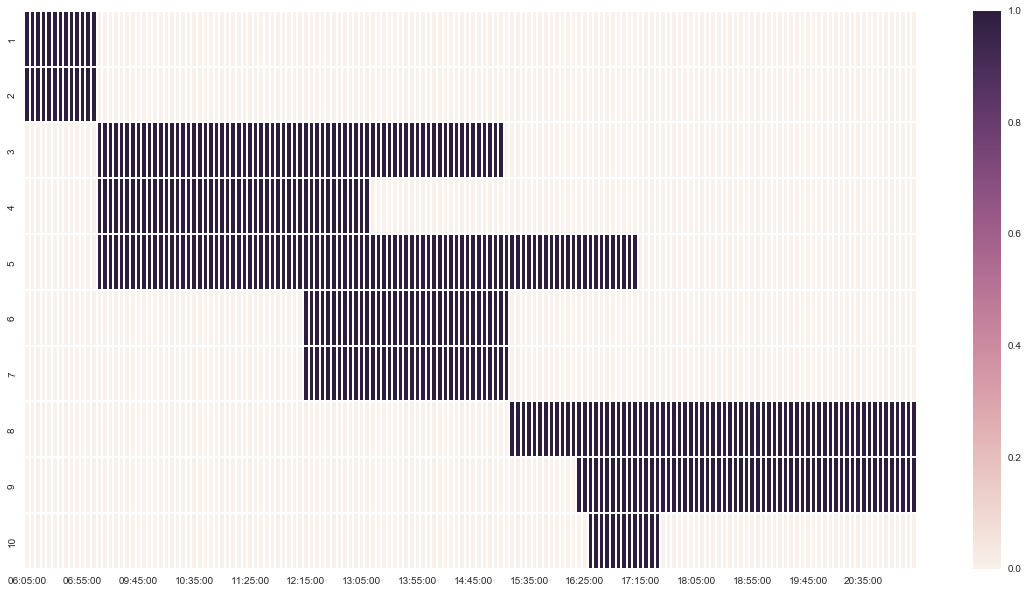

In [16]:
# Plot the turns in the airport
sns.set()
plt.figure(figsize=(20, 10))

snsdf = heatmapdf.T
g = sns.heatmap(snsdf, rasterized=True, xticklabels=10, linewidths=1)

In [17]:
# We don't need duplicate constraints (at different time buckets)
heatmapdf = heatmapdf.drop_duplicates()
heatmapdf.head()

,1,2,3,4,5,6,7,8,9,10
06:05:00,1,1,0,0,0,0,0,0,0,0
09:10:00,0,0,1,1,1,0,0,0,0,0
12:15:00,0,0,1,1,1,1,1,0,0,0
13:15:00,0,0,1,0,1,1,1,0,0,0
15:15:00,0,0,0,0,1,1,1,0,0,0


In [18]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in compatible_gates[t]:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one (compatible) gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1

Instead of:
    
```
t10_gA1 + t1_gA1 + t2_gA1 + t3_gA1 + t4_gA1 + t5_gA1 + t6_gA1 + t7_gA1 + t8_gA1 + t9_gA1 <= 1
t10_gA2 + t1_gA2 + t2_gA2 + t3_gA2 + t4_gA2 + t5_gA2 + t6_gA2 + t7_gA2 + t8_gA2 + t9_gA2 <= 1
t10_gA3 + t1_gA3 + t2_gA3 + t3_gA3 + t4_gA3 + t5_gA3 + t6_gA3 + t7_gA3 + t8_gA3 + t9_gA3 <= 1
t10_gB1 + t1_gB1 + t2_gB1 + t3_gB1 + t4_gB1 + t5_gB1 + t6_gB1 + t7_gB1 + t8_gB1 + t9_gB1 <= 1
t10_gC1 + t1_gC1 + t2_gC1 + t3_gC1 + t4_gC1 + t5_gC1 + t6_gC1 + t7_gC1 + t8_gC1 + t9_gC1 <= 1
t10_gC2 + t1_gC2 + t2_gC2 + t3_gC2 + t4_gC2 + t5_gC2 + t6_gC2 + t7_gC2 + t8_gC2 + t9_gC2 <= 1
```

We can relax the constraint

In [19]:
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        # Only need to impose constraint if there is an overlap
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            print(row.name, ":", constraint_for_time_bucket)
            prob += constraint_for_time_bucket

06:05:00 : t1_gA1 + t2_gA1 <= 1
06:05:00 : t1_gB1 + t2_gB1 <= 1
09:10:00 : t3_gA1 + t4_gA1 + t5_gA1 <= 1
09:10:00 : t4_gA2 + t5_gA2 <= 1
09:10:00 : t3_gA3 + t4_gA3 + t5_gA3 <= 1
09:10:00 : t3_gB1 + t4_gB1 + t5_gB1 <= 1
09:10:00 : t4_gC1 + t5_gC1 <= 1
09:10:00 : t4_gC2 + t5_gC2 <= 1
12:15:00 : t3_gA1 + t4_gA1 + t5_gA1 + t6_gA1 + t7_gA1 <= 1
12:15:00 : t4_gA2 + t5_gA2 + t6_gA2 <= 1
12:15:00 : t3_gA3 + t4_gA3 + t5_gA3 + t6_gA3 <= 1
12:15:00 : t3_gB1 + t4_gB1 + t5_gB1 + t6_gB1 + t7_gB1 <= 1
12:15:00 : t4_gC1 + t5_gC1 + t6_gC1 <= 1
12:15:00 : t4_gC2 + t5_gC2 + t6_gC2 <= 1
13:15:00 : t3_gA1 + t5_gA1 + t6_gA1 + t7_gA1 <= 1
13:15:00 : t5_gA2 + t6_gA2 <= 1
13:15:00 : t3_gA3 + t5_gA3 + t6_gA3 <= 1
13:15:00 : t3_gB1 + t5_gB1 + t6_gB1 + t7_gB1 <= 1
13:15:00 : t5_gC1 + t6_gC1 <= 1
13:15:00 : t5_gC2 + t6_gC2 <= 1
15:15:00 : t5_gA1 + t6_gA1 + t7_gA1 <= 1
15:15:00 : t5_gA2 + t6_gA2 <= 1
15:15:00 : t5_gA3 + t6_gA3 <= 1
15:15:00 : t5_gB1 + t6_gB1 + t7_gB1 <= 1
15:15:00 : t5_gC1 + t6_gC1 <= 1
15:15:00 : 

In [20]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

Status:  Optimal
Minimised Cost:  None


In [21]:
# Create a function that we can call to visualise
def plot_gantt_chart(allocated_turns, lp_variable_outcomes, min_bucket=5):
    
    # Assign gate
    for alloc in lp_variable_outcomes:
        if lp_variable_outcomes[alloc].varValue:
            allocated_turns.set_value(allocated_turns['turn_no'] == alloc[0], 'gate', alloc[-1])
                
    # Create time-series between arrival of first plane and departure of last
    time_series = pd.Series(True, index= pd.date_range(
            start=turns2.inbound_arrival.min(),
            end=turns2.outbound_departure.max(),
            freq=pd.offsets.Minute(min_bucket)))

    # Truncate full time-series to [inbound_arrival, outbound_departure]
    def trunc_ts(series):
        return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])

    # Allocations heat-map
    allocheatmapdf = allocated_turns.apply(trunc_ts, axis=1).T
    allocheatmapdf.columns = allocated_turns['turn_no'].get_values()
    allocheatmapdf = allocheatmapdf.fillna(0).astype(int)
    allocheatmapdf.index = allocheatmapdf.index.time
    
    # Replace values with col-names
    for col in list(allocheatmapdf.columns):
        allocheatmapdf.loc[allocheatmapdf[col] > 0, col] = col
          
    # Columns are now stands
    allocheatmapdf.columns = allocated_turns['gate'].get_values()  
    trans = allocheatmapdf.T

    # These will never overlap given the constraints
    plt_df = trans.groupby(trans.index).sum()

    # Plot
    sns.set()
    plt.figure(figsize=(20, 10))
    g = sns.heatmap(plt_df, xticklabels=10, cmap='nipy_spectral')

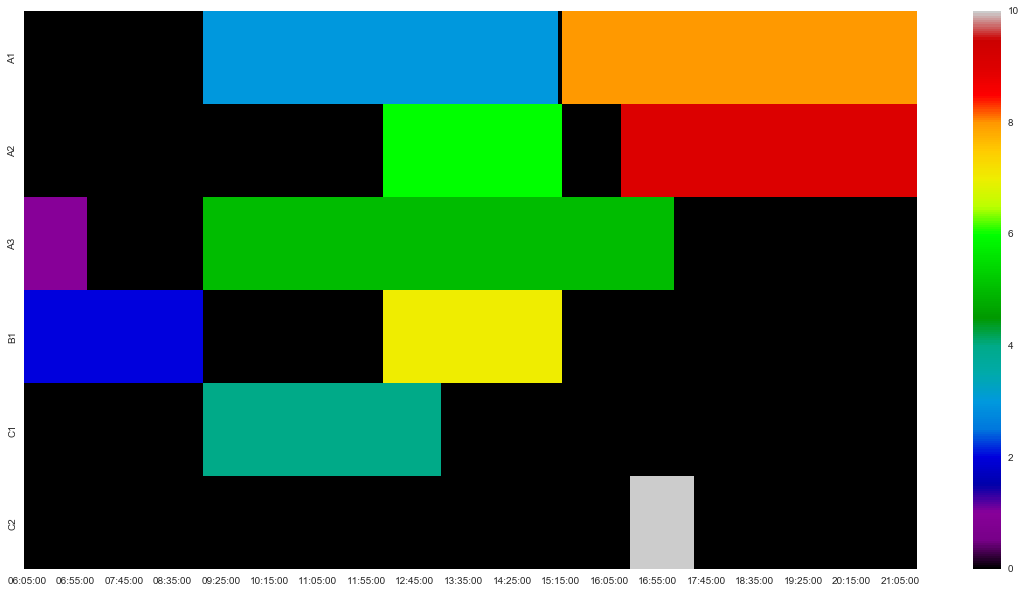

In [22]:
# Plot turn-gate assignment
plot_gantt_chart(allocated_turns=turns2, lp_variable_outcomes=x)

In [23]:
# Remind ourselves of the allocations:
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

Turn 4 assigned to gate C1
Turn 3 assigned to gate A1
Turn 8 assigned to gate A1
Turn 7 assigned to gate B1
Turn 10 assigned to gate C2
Turn 5 assigned to gate A3
Turn 6 assigned to gate A2
Turn 2 assigned to gate B1
Turn 1 assigned to gate A3
Turn 9 assigned to gate A2


## Model D - More Implicit Constraints (occupancy of stands)

There could be two ways that a gate is not compatible:

1. The plane is not the correct size for the gate
2. The gate is already occupied

Previously we assumed we were landing in an empty airport

However some stands may be taken ...

In [24]:
occupancy = pd.DataFrame({
    'gate':['A3', 'A2'],
    'occupied_from':pd.to_datetime(["02/01/2016 15:15", "02/01/2016 13:15"]),
    'occupied_to':pd.to_datetime(["02/01/2016 19:15", "02/01/2016 14:15"]),
    }, columns=['gate', 'occupied_from', 'occupied_to'])

occupancy

,gate,occupied_from,occupied_to
0,A3,2016-02-01 15:15:00,2016-02-01 19:15:00
1,A2,2016-02-01 13:15:00,2016-02-01 14:15:00


In [25]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                print("Gate %s is occupied during time of Turn %d"  % (g, t))
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)
        print("Created variable for gate %s for turn %d" % (g, t))

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket
            
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))        

Created variable for gate A1 for turn 1
Created variable for gate A3 for turn 1
Created variable for gate B1 for turn 1
Created variable for gate A1 for turn 2
Created variable for gate B1 for turn 2
Created variable for gate A1 for turn 3
Created variable for gate A3 for turn 3
Created variable for gate B1 for turn 3
Created variable for gate A1 for turn 4
Created variable for gate A2 for turn 4
Created variable for gate A3 for turn 4
Created variable for gate B1 for turn 4
Created variable for gate C1 for turn 4
Created variable for gate C2 for turn 4
Created variable for gate A1 for turn 5
Gate A2 is occupied during time of Turn 5
Gate A3 is occupied during time of Turn 5
Created variable for gate B1 for turn 5
Created variable for gate C1 for turn 5
Created variable for gate C2 for turn 5
Created variable for gate A1 for turn 6
Gate A2 is occupied during time of Turn 6
Gate A3 is occupied during time of Turn 6
Created variable for gate B1 for turn 6
Created variable for gate C1 for

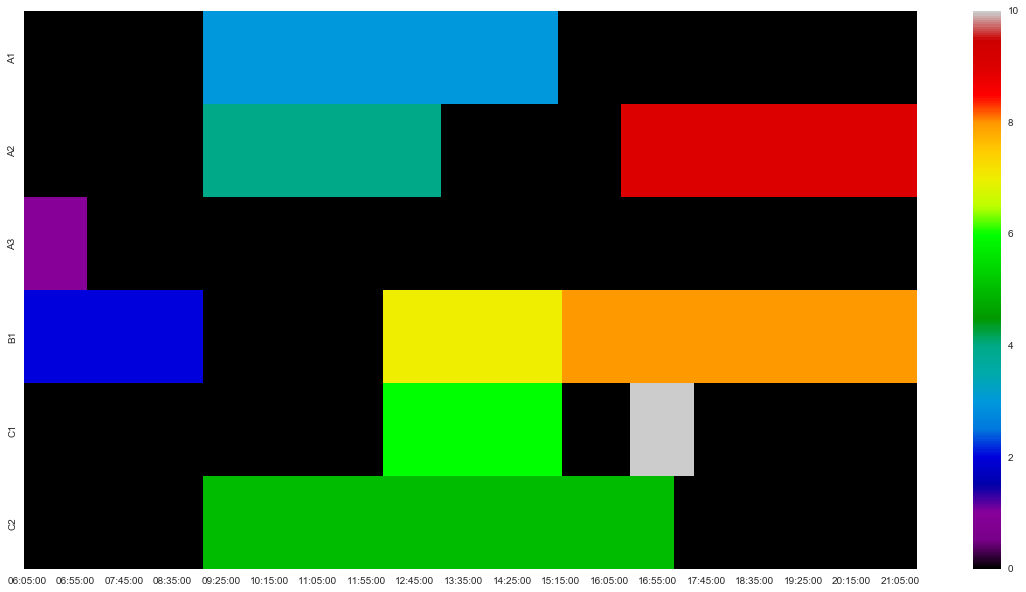

In [26]:
# Visualise outcome
plot_gantt_chart(turns2, x)

# We can see a quiet period during the blockage

## Model E - Explicit Constraints

In [27]:
# Imagine we cannot use gate C1 for any turn, instead of removing the variable as before
# We can add it as an explicit constraint
# The below follows just like before:

# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                print("Gate %s is occupied during time of Turn %d"  % (g, t))
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)
        print("Created variable for gate %s for turn %d" % (g, t))

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

Created variable for gate A1 for turn 1
Created variable for gate A3 for turn 1
Created variable for gate B1 for turn 1
Created variable for gate A1 for turn 2
Created variable for gate B1 for turn 2
Created variable for gate A1 for turn 3
Created variable for gate A3 for turn 3
Created variable for gate B1 for turn 3
Created variable for gate A1 for turn 4
Created variable for gate A2 for turn 4
Created variable for gate A3 for turn 4
Created variable for gate B1 for turn 4
Created variable for gate C1 for turn 4
Created variable for gate C2 for turn 4
Created variable for gate A1 for turn 5
Gate A2 is occupied during time of Turn 5
Gate A3 is occupied during time of Turn 5
Created variable for gate B1 for turn 5
Created variable for gate C1 for turn 5
Created variable for gate C2 for turn 5
Created variable for gate A1 for turn 6
Gate A2 is occupied during time of Turn 6
Gate A3 is occupied during time of Turn 6
Created variable for gate B1 for turn 6
Created variable for gate C1 for

In [28]:
# Explicit constraint
# Close C1 ... we may wish to close a certain terminal like this for certain flights
gate_closed = "C1"
gate_closed_constraint = lpSum(x[t, gate_closed] for t in turn_list if (t, gate_closed) in x) == 0
print(gate_closed_constraint)
prob += gate_closed_constraint

t10_gC1 + t4_gC1 + t5_gC1 + t6_gC1 + t8_gC1 + t9_gC1 = 0


In [29]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

Status:  Optimal
Minimised Cost:  None
Turn 4 assigned to gate A2
Turn 6 assigned to gate C2
Turn 3 assigned to gate A3
Turn 2 assigned to gate B1
Turn 10 assigned to gate C2
Turn 8 assigned to gate A2
Turn 7 assigned to gate A1
Turn 9 assigned to gate A1
Turn 1 assigned to gate A3
Turn 5 assigned to gate B1


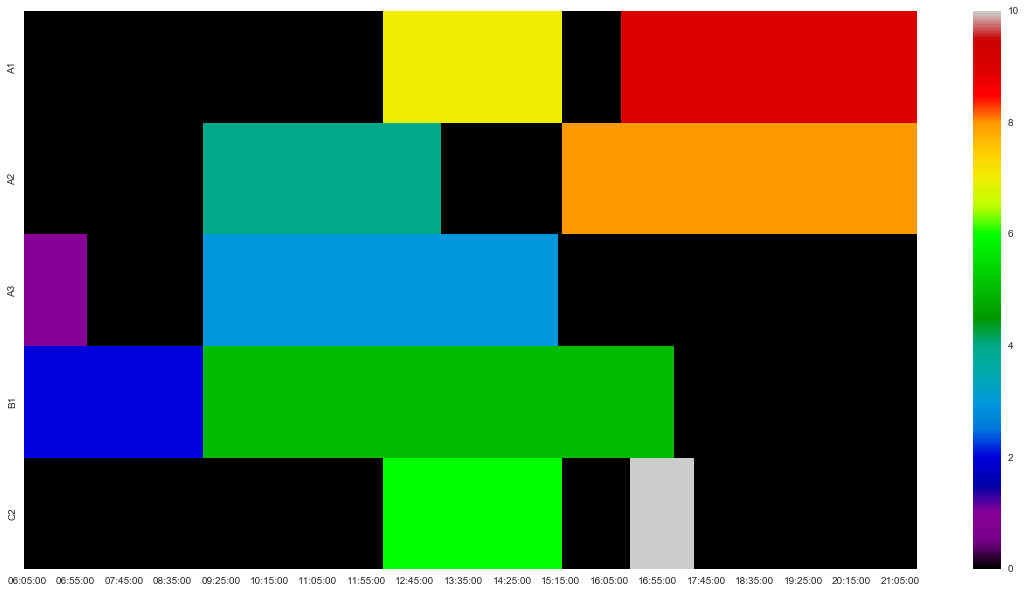

In [30]:
# Visualise outcome
plot_gantt_chart(turns2, x)

In [31]:
# Save for part 2
pickle.dump(airport, open("airport.p", "wb"))
pickle.dump(turns2, open("turns2.p", "wb"))
pickle.dump(occupancy, open("occupancy.p", "wb"))
pickle.dump(heatmapdf, open("heatmapdf.p", "wb"))